<a href="https://colab.research.google.com/github/johhan27/fifa_analysis/blob/main/fifa_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Analysis of FIFA 21 (video game) to understand what makes a good player vs what makes a player valuable in the market

Johan Sanchez 
04/30/2021

#GOALS 

0) Exploratory plots

    -Player Value vs Overall and their distributions.
    -Potential vs Overall by age group.
    -Overall vs Year of contract.
    -Player value by age group
    

1) predicting overall player score with skills only(without "player value", "player wage", "potential score" and others)

2) predicting player market value with skills only and compare what makes a good player vs what makes a valuable player


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
!pip install category_encoders
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
!pip install eli5
!pip install pdpbox

     |████████████████████████████████| 81kB 3.1MB/s 
     - 38.3MB 873kB/s
     |████████████████████████████████| 81kB 3.5MB/s 
     |████████████████████████████████| 1.1MB 29.6MB/s 
     |████████████████████████████████| 3.2MB 36.5MB/s 
     |████████████████████████████████| 61kB 5.3MB/s 
     |████████████████████████████████| 81kB 6.8MB/s 
     |████████████████████████████████| 296kB 40.8MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-2.12.0-py2.py3-none-any.whl size=243829 sha256=97bf4641c85f573a4db53acb080c73f7923832d51fae4f2fa3bed705135f46e2
  Stored in directory: /tmp/pip-ephem-wheel-cache-8lzhlap8/wheels/56/c2/dd/8d945b0443c35df7d5f62fa9e9ae105a2d8b286302b92e0109
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp37-none-any.whl size=27085 sha256=a9194c583c3519898f413992bb6c583c9427a6e4efa6378e072ebd93c37a56b6
  Stored in directory: /root/.cache/pip/wheels/43/07/ac/7c5a9d708d65247ac1f94066cf1db075540b85716c30255459
  Created wheel for phik: filen

In [2]:
players_21 = pd.read_csv('players_21.csv')
df_21 = pd.read_csv('players_21.csv')

In [3]:
df_21.set_index('sofifa_id', inplace=True)

#PART 0: Exploratory Plots


**Player Value vs Overall and their distributions. The higher the overall score the higher the value_eur. Also, we notice that the overall distribution is Normal, but value_eur is very skewed**

Pearson's correlation coefficient overall/value_eur 0.6300851207029855
Spearman's correlation coefficient overall/value_eur 0.9085779633550735


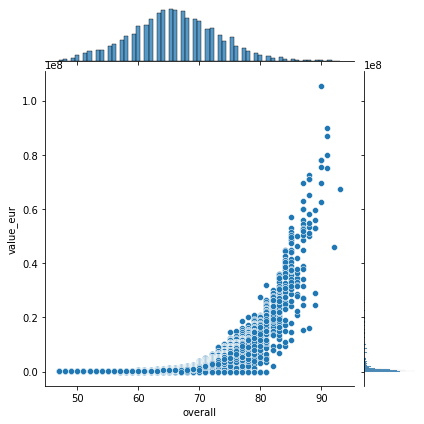

In [5]:
from scipy.stats import pearsonr, spearmanr

corr, _ = pearsonr(df_21['overall'], df_21['value_eur'])
print ("Pearson's correlation coefficient overall/value_eur", corr)

corr, _ = spearmanr(df_21['overall'], df_21['value_eur'])
print ("Spearman's correlation coefficient overall/value_eur", corr)

sns.jointplot(data=df_21, x='overall', y='value_eur')

**Potential vs Overall by age group. Players reach their potential at 30 years old**

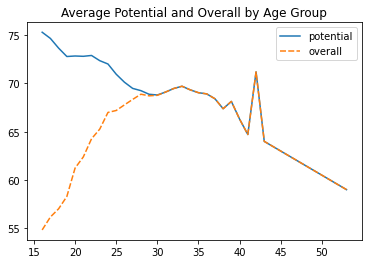

In [6]:
query = pd.DataFrame({'potential':df_21.groupby('age')['potential'].mean(),
                      'overall':df_21.groupby('age')['overall'].mean()},
                      index =df_21.groupby('age')['potential'].mean().index.to_list())
  
# print the data
sns.lineplot(data=query).set_title("Average Potential and Overall by Age Group")
plt.show()

**Overall vs Year of contract. Players with the longest contracts have a higher average overall score**

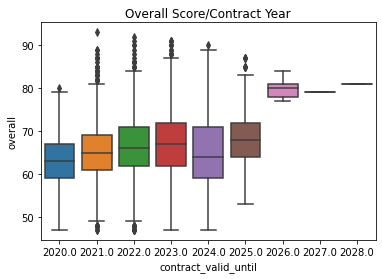

In [7]:
sns.boxplot(x='contract_valid_until', y='overall', data=df_21).set_title("Overall Score/Contract Year")
plt.show()

**Player value by age group. Players are at their peak value at the 26-30 age range**

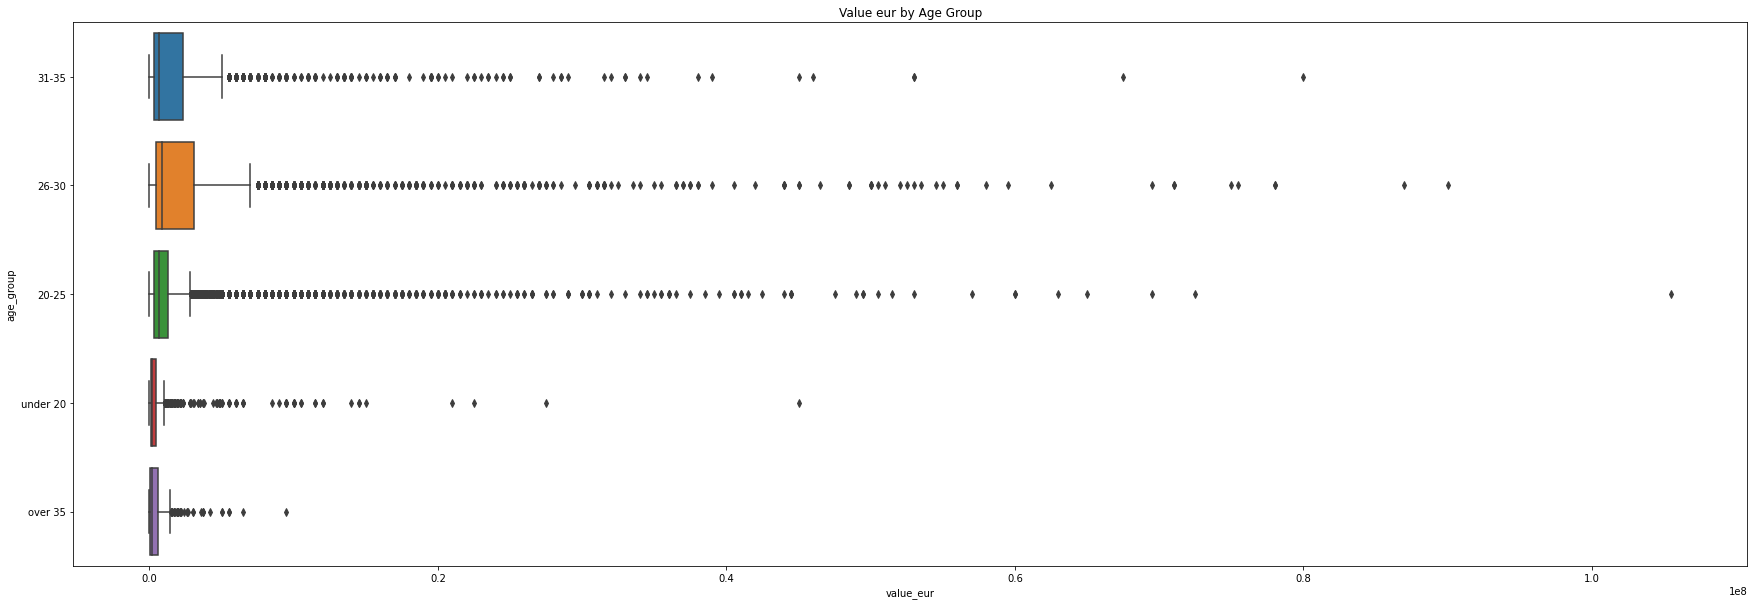

In [8]:
def age_group_encoder(age):
  if age < 20:
    return "under 20"
  elif age < 26:
    return "20-25"
  elif age < 31:
    return "26-30"
  elif age < 36:
    return "31-35"
  elif age > 35:
    return "over 35"    

df_21["age_group"] = df_21['age'].apply(age_group_encoder)

f, ax = plt.subplots(figsize=(30, 10))
sns.boxplot(x='value_eur', y='age_group', data=df_21, orient="h").set_title("Value eur by Age Group")
plt.show()

In [9]:
pd.DataFrame(df_21.groupby('age_group')['value_eur'].mean())

,value_eur
age_group,
20-25,2.103002e+06
26-30,3.052088e+06
31-35,2.285212e+06
over 35,5.691469e+05
under 20,5.790260e+05


#PART 1: Predicting Overall score with skills only

In [10]:
def wrangle_21(df):

  #setting the index
  df.set_index('sofifa_id', inplace=True)

  #useless columns
  useless_cols = ['height_cm','weight_kg', 'team_jersey_number', 'nation_jersey_number', 'player_url', 'short_name', 'dob', 'real_face', 'player_tags', 'joined', 'body_type']
  df.drop(useless_cols, axis=1, inplace=True)

  #encoding player position into 3 categories: Goal Keeper, Defender, Midfielder, Attacker
  def position_encoder(position):
    position_dict = {'W':'Attacker', 'T':'Attacker', 'F':'Attacker', 'M':'Midfielder', 'B':'Defender', 'K':'Goal Keeper'}
    return position_dict[position[:3].strip(',')[-1]]
  df['player_positions'] = df['player_positions'].apply(position_encoder)

  #encoding "work rate"
  def wr_encoder(rate):
    wr_dict = {'Low':1, 'Medium':2, 'High':3}

    if type(rate) != str:
      return float('nan')
    else:   
      attack, defense = rate.split('/')
      return wr_dict[attack.strip()]*wr_dict[defense.strip()]

  df['work_rate'] = df['work_rate'].apply(wr_encoder)

  #dropping high cardinality cols (over 10)

  high_card_cols = [col for col in df.describe(exclude='number').columns.to_list() if df[col].nunique() > 10]
  df.drop(high_card_cols, axis=1, inplace=True)

  #dropping empty col

  df.drop('defending_marking', axis=1, inplace=True)


  return df

players_21 = wrangle_21(players_21)

In [11]:
from pandas_profiling import ProfileReport
#profile = ProfileReport(players_21, title="Players FIFA 21 data", minimal=True)
#profile.to_notebook_iframe()

##ProfileReport FIFA21

A) *Multiple NaN that could be the same rows:*

league_rank - contract_valid_until - wage_eur(zeros)

Total rows : 225, might be inactive players

""""""""""""

B) *Zeros*

value_eur: 237  > wage_eur: 225

Maybe players finilizing contracts 

""""""""""""

C) *Missing*

release_clause_eur: 995 

Perhaps free agents or unprotected players (filtering out  the inactive ones)

"""""""""""

D) *Missing: 2083 (Goalkeepers?)*

pace
shooting
passing
dribbling
defending
physic

"""""""

E) *Missing:16861 (Non-Goal Keepers?)*

gk_positioning
gk_speed
gk_reflexes
gk_kicking
gk_handling
gk_diving

**Part A) players with league_rank = NaN, contract_valid_until = NaN, wage_eur=0. There are 225 inactive players**

In [12]:
#Part A

#players with NaN values on 'league_rank', 'contract_valid_until' and 'wage_eur'=0
query = players_21[(players_21['league_rank'].isna()==True) & (players_21['contract_valid_until'].isna()==True) & (players_21['wage_eur'] == 0)].isna().sum()
query[query > 0]

league_rank             225
release_clause_eur      225
contract_valid_until    225
pace                     30
shooting                 30
passing                  30
dribbling                30
defending                30
physic                   30
gk_diving               195
gk_handling             195
gk_kicking              195
gk_reflexes             195
gk_speed                195
gk_positioning          195
dtype: int64

**"Part B) player with wages_eur > 0 but value_eur = 0 . 12 active players about to retire"**

In [13]:
#Part B

#Let's see those player with wages_eur > 0 but value_eur = 0  
players_21[(players_21['value_eur'] == 0) & (players_21['wage_eur'] > 0)]

,age,league_rank,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,release_clause_eur,contract_valid_until,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
sofifa_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
153260,42,1.0,77,77,0,20000,Defender,Right,2,4,3,4,NaN,2021.0,33.0,51.0,67.0,65.0,81.0,70.0,NaN,NaN,NaN,NaN,NaN,NaN,60,45,79,73,51,64,54,48,72,72,32,33,54,70,58,55,81,52,75,58,75,84,50,67,64,77,80,77,12,7,11,12,13
140067,40,1.0,71,71,0,500,Defender,Right,1,3,2,2,NaN,2023.0,42.0,36.0,61.0,58.0,70.0,70.0,NaN,NaN,NaN,NaN,NaN,NaN,68,35,61,64,28,52,37,46,62,68,41,43,49,67,62,38,80,47,80,32,72,74,40,56,55,70,75,74,9,15,6,15,8
113524,40,1.0,70,70,0,9000,Attacker,Right,2,4,3,4,NaN,2021.0,57.0,74.0,63.0,70.0,46.0,55.0,NaN,NaN,NaN,NaN,NaN,NaN,59,80,55,68,59,69,65,68,49,68,61,53,73,80,80,66,75,32,63,69,60,49,79,65,75,81,42,37,10,6,15,12,6
136553,41,1.0,69,69,0,5000,Attacker,Right,3,4,2,3,NaN,2020.0,32.0,77.0,62.0,58.0,29.0,62.0,NaN,NaN,NaN,NaN,NaN,NaN,65,79,75,60,88,54,78,68,52,70,33,32,33,62,63,75,73,32,83,67,44,32,78,65,86,73,15,16,11,6,12,10,9
186359,40,1.0,69,69,0,500,Attacker,Right,1,2,3,4,NaN,2023.0,75.0,60.0,64.0,68.0,45.0,65.0,NaN,NaN,NaN,NaN,NaN,NaN,69,63,32,69,36,68,59,40,45,69,79,71,73,68,43,51,32,86,63,69,50,39,69,74,46,55,44,40,8,14,14,13,10
140196,40,1.0,68,68,0,4000,Midfielder,Right,3,3,3,6,NaN,2021.0,30.0,65.0,75.0,66.0,65.0,63.0,NaN,NaN,NaN,NaN,NaN,NaN,76,60,60,73,63,66,81,85,71,70,30,30,61,62,64,70,31,52,73,66,58,67,68,75,82,82,65,63,15,9,15,14,7
140222,40,1.0,67,67,0,500,Defender,Right,2,3,2,3,NaN,2021.0,30.0,35.0,45.0,49.0,66.0,71.0,NaN,NaN,NaN,NaN,NaN,NaN,35,34,65,61,29,37,16,28,50,62,32,29,53,58,64,36,77,48,82,36,70,62,38,36,43,70,67,64,9,8,15,16,9
29552,42,1.0,65,65,0,1000,Midfielder,Left,3,3,3,3,NaN,2021.0,30.0,69.0,74.0,67.0,36.0,51.0,NaN,NaN,NaN,NaN,NaN,NaN,80,63,28,70,78,66,87,90,68,68,31,29,68,63,66,74,33,34,69,71,30,33,67,71,83,77,38,34,8,6,7,15,6
208927,43,1.0,64,64,0,5000,Defender,Left,1,3,3,6,NaN,2024.0,43.0,53.0,68.0,64.0,64.0,72.0,NaN,NaN,NaN,NaN,NaN,NaN,70,43,61,67,43,63,69,69,68,64,41,44,64,64,68,65,69,58,72,63,92,65,64,68,60,66,66,63,15,8,15,14,13


**Part C) Players with age<26, potential>82 and release_clause_eur = 0. 30 players that are "Diamonds in the Rough" at a bargain**

In [14]:
#Part C
#Active players with no release_clause_eur
query = players_21[(players_21['release_clause_eur'].isna()==True) & (players_21['wage_eur'] > 0)]
query = query[(query['age'] < 26) & (query['potential'] > 82)]
print (query.shape)
#query.head()

(30, 59)


In [15]:
deals_21 = df_21.loc[query.index.to_list()][['long_name', 'potential','value_eur','nationality', 'club_name', 'player_positions']]
deals_21.to_excel('good_deals.xlsx')
deals_21

,long_name,potential,value_eur,nationality,club_name,player_positions
sofifa_id,,,,,,
220651,José Ángel Esmoris Tasende,85,17500000,Spain,RB Leipzig,LB
222509,Daniel Ceballos Fernández,85,19500000,Spain,Arsenal,"CM, CAM"
224254,Cristian David Pavón,85,17500000,Argentina,LA Galaxy,"LW, RW, LM"
211147,Valentino Lazaro,83,16500000,Austria,Borussia Mönchengladbach,"RM, RWB, RB"
231691,Alban Lafont,84,11000000,France,FC Nantes,GK
212692,Marcos Paulo Mesquita Lopes,83,14000000,Portugal,OGC Nice,"LW, LM"
234833,Florian Müller,83,8000000,Germany,SC Freiburg,GK
237681,久保 建英,89,14500000,Japan,Villarreal CF,"RM, CM, CAM"
234060,Yangel Clemente Herrera Ravelo,84,10000000,Venezuela,Granada CF,"CM, CDM"


**Extra: Amazing Free Players. value_eur=0, potential>80!**

In [16]:
query = players_21[(players_21['value_eur'] == 0) & (players_21['potential']>80)]
free_deals = df_21.loc[query.index.to_list()][['long_name', 'age', 'value_eur', 'wage_eur','potential','nationality', 'club_name', 'player_positions']]
free_deals.to_excel("free_deals.xlsx")
free_deals

,long_name,age,value_eur,wage_eur,potential,nationality,club_name,player_positions
sofifa_id,,,,,,,,
230225,Juan Everton Mestres de Mesquita,24,0,0,81,Brazil,NaN,"CB, CDM"
230347,Welington Kauê Dano Nascimento,20,0,0,81,Brazil,NaN,"LB, LM"
214394,Wílmar Enrique Barrios Terán,26,0,0,84,Colombia,NaN,"CDM, CM"
222404,Mathias Antonsen Normann,24,0,0,81,Norway,NaN,"CDM, CM"
235973,Sebastian Szymański,21,0,0,83,Poland,NaN,"RM, CAM"


**Part D and E) The missing skills correspond to Goal Keepers and Non-Goal Keepers, except for 1 Goal Keeper that could be an error**

In [17]:
#Part D and E

#Missing values in certain skills
query = players_21[players_21['pace'].isna()==True]
print ("Player with Pace=NaN ----->", query['player_positions'].value_counts())
print (" ")
query = players_21[players_21['gk_diving'].isna()==True]
print ("Player with gf_diving=NaN ----->", query['player_positions'].value_counts())

Player with Pace=NaN -----> Goal Keeper    2083
Name: player_positions, dtype: int64
 
Player with gf_diving=NaN -----> Midfielder     7037
Defender       6205
Attacker       3618
Goal Keeper       1
Name: player_positions, dtype: int64


## Creating the Model

Separate target and features, using only numeric values and dropping money related columns and "potential"

In [18]:
target = 'overall'
features = players_21.describe().columns.to_list()
for col in [target, 'potential', 'value_eur', 'wage_eur', 'release_clause_eur', 'contract_valid_until']:
  features.remove(col)

X = players_21[features]
y = players_21[target]

Train-Test Splitting 

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Create the model 

In [20]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from category_encoders.ordinal import OrdinalEncoder
import xgboost as xgb

model = make_pipeline(
    SimpleImputer(strategy='median'),
    OrdinalEncoder(),
    xgb.XGBRegressor()
)

model.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[01:22:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(memory=None,
         steps=[('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booste...
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=3, min_child_weight=1,
                              missing=None, n_estimators=100, n_jobs=1,
                              nthread=None, objective=

Let's check our metrics 

In [21]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

mae = mean_absolute_error(y_test, model.predict(X_test))
r2 = r2_score(y_test, model.predict(X_test))

print("MAE", mae)
print("r2_score", r2)
print()

y_train_mean = y_train.mean()
baseline_mae = mean_absolute_error(y_test, [y_train_mean for times in range(len(y_test))])
baseline_r2 = r2_score(y_test, [y_train_mean for times in range(len(y_test))])
print ("baseline_mae", baseline_mae)
print ("baseline_r2", baseline_r2)

MAE 1.0973174009121769
r2_score 0.955884177635431

baseline_mae 5.476817301854519
baseline_r2 -1.5623505356110456e-07


Feature Importances 

Target: Overall

In [22]:
import eli5
from eli5.sklearn import PermutationImportance

overall_perm = PermutationImportance(model, random_state=42).fit(X_test, y_test)
eli5.show_weights(overall_perm, feature_names = X_test.columns.tolist())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Weight,Feature
0.2555 ± 0.0041,movement_reactions
0.0584 ± 0.0021,defending
0.0459 ± 0.0016,skill_ball_control
0.0186 ± 0.0014,mentality_composure
0.0186 ± 0.0008,attacking_crossing
0.0175 ± 0.0005,physic
0.0105 ± 0.0008,pace
0.0104 ± 0.0006,dribbling
0.0092 ± 0.0004,attacking_short_passing
0.0089 ± 0.0006,attacking_finishing


#Part 2: Predicting value_eur with the same features used for "overall"

Different Target same features

In [23]:
target = 'value_eur'

y = players_21[target]

Train-Test Split 

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Setting up the model 

In [25]:
model = make_pipeline(
    SimpleImputer(strategy='median'),
    OrdinalEncoder(),
    xgb.XGBRegressor()
)

model.fit(X_train, y_train)

[01:22:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(memory=None,
         steps=[('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booste...
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=3, min_child_weight=1,
                              missing=None, n_estimators=100, n_jobs=1,
                              nthread=None, objective=

Let's see the metrics 



In [26]:
mae = mean_absolute_error(y_test, model.predict(X_test))
r2 = r2_score(y_test, model.predict(X_test))

print("MAE", mae)
print("r2_score", r2)
print()

y_train_mean = y_train.mean()
baseline_mae = mean_absolute_error(y_test, [y_train_mean for times in range(len(y_test))])
baseline_r2 = r2_score(y_test, [y_train_mean for times in range(len(y_test))])
print ("baseline_mae", baseline_mae)
print ("baseline_r2", baseline_r2)

MAE 643299.4910547766
r2_score 0.8886623182022121

baseline_mae 2561344.0734703946
baseline_r2 -2.300502317975628e-06


Feature Importances 

target = value_eur

In [27]:
value_eur_perm = PermutationImportance(model, random_state=42).fit(X_test, y_test)

eli5.show_weights(value_eur_perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.3785 ± 0.0123,movement_reactions
0.0996 ± 0.0153,age
0.0607 ± 0.0005,skill_ball_control
0.0145 ± 0.0008,international_reputation
0.0139 ± 0.0012,attacking_crossing
0.0139 ± 0.0009,attacking_finishing
0.0131 ± 0.0020,attacking_short_passing
0.0127 ± 0.0005,gk_reflexes
0.0120 ± 0.0013,skill_dribbling
0.0114 ± 0.0069,movement_sprint_speed


Let's compare the importances along the top value_eur features

In [28]:
value_eur_importances = pd.DataFrame({"importance":value_eur_perm.feature_importances_, "feature":X_test.columns.to_list()})
value_eur_importances['target'] = 'value_eur' 

overall_importances = pd.DataFrame({"importance":overall_perm.feature_importances_, "feature":X_test.columns.to_list()})
overall_importances['target'] = 'overall' 

all_importances = pd.concat([value_eur_importances, overall_importances], ignore_index=True)

value_eur_top_features = all_importances[all_importances['target'] == 'value_eur'].sort_values(by='importance', ascending=False)[:5]['feature'].to_list()

Text(0.5, 1.0, 'Feature Importance comparison (value_eur top 5 features)')

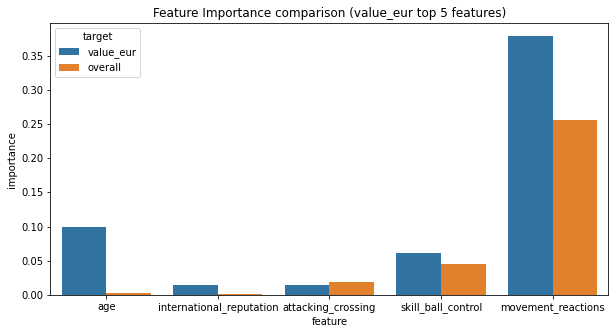

In [29]:
f, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=all_importances[all_importances['feature'].isin(value_eur_top_features)], y='importance', x='feature', hue='target').set_title("Feature Importance comparison (value_eur top 5 features)")

## We can notice that "movement_reactions" and "skill_ball_control" are even more decisive when predicting value_eur. However, "age" is 2nd and "international_reputation" 4th in this top. What makes a young player shine and earn that reputation? We'll discuss that later on the continuation of this project

##As a wrap up, let's check out the interaction between "movement_reactions" and "international_reputation"

**"international_reputation" has a significant impact in "value_eur" along all "movement_reactions" levels**

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f19280b2a50>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f1928152510>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


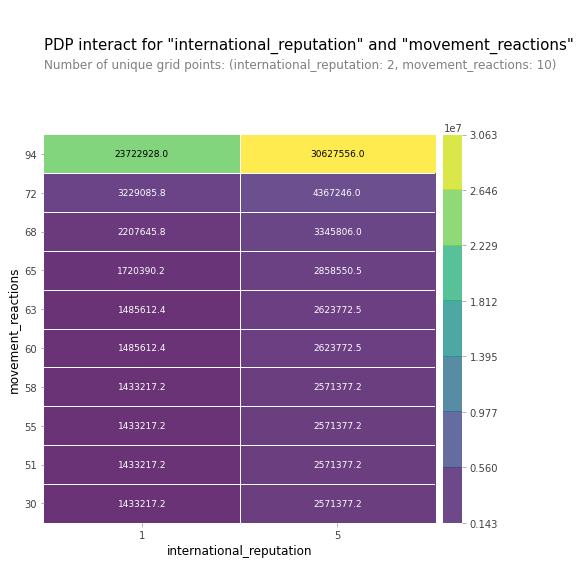

In [30]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['international_reputation','movement_reactions' ]

X_test_imputed = pd.DataFrame(SimpleImputer(strategy='median').fit_transform(X_test), columns=X_test.columns)

interaction = pdp_interact(
    model = model, 
    dataset=X_test_imputed, 
    model_features=X_test.columns, 
    features = features
)

pdp_interact_plot(interaction, plot_type='grid',feature_names = features)